Some code inherited from christianversloot (github)'s machine learning articles and Deep Learning in Python (Chollet)

Preprocessing:

In [1]:
# importing the sys module
import sys
sys.path.append('C:/Users/nsshi/github/Coeus/src/modules')  
import lib
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

# File data
save_dir = '/modelsOut/'
emg_filename = r'Data\EMG_Mar_19_09_34_15.txt'
q_filename = r'Data\Q_Mar_19_09_33_45.txt'

# Preprocessing
emg, emgTimes, q, qTimes = lib.import_files(emg_filename, q_filename, old=True)
qF, emgF, tF, timestampsF = lib.unify_timeseries_high(emg, emgTimes, q, qTimes)
emgModel = lib.normalize_emg_rolling(emgF)
qModel = lib.finger_nodes(qF, finger = 'indextip')


K-Fold Validation Example:

In [ ]:
# Create timeseries dataset
sequence_length = 100
data, targets, input_shape, output_shape = lib.create_dataset_cv(tF, emgModel, qModel, sequence_length = sequence_length)

In [ ]:
# K-fold Cross Validation model evaluation
number_folds = 3
fold_index = 0

# Define the K-fold Cross Validator
kfold = KFold(n_splits= number_folds, shuffle=True)

for train_ind, test_ind in kfold.split(data, targets):

  # Normalize
  data = (data-np.mean(data[train_ind], axis=0))/np.std(data[train_ind], axis=0)

  # Model parameters
  do = 0.8  # Dropout rate
  loss_function = "mse"
  optimizer = "adam"
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
  batch_size = 256
  no_epochs = 5
  verbosity = 1

  callbacks = [
    tf.keras.callbacks.ModelCheckpoint(save_dir + lib.get_model_name(fold_index), 
      monitor='val_accuracy', verbose=1, 
      save_best_only=True, mode='max')]

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the model architecture
  inputs = keras.Input(shape=(sequence_length, input_shape))

  # Recurrent layers
  x = layers.GRU(4, recurrent_dropout=do, return_sequences=True)(inputs)
  x = layers.GRU(4, recurrent_dropout=do, return_sequences=True)(x)
  x = layers.GRU(4, recurrent_dropout=do)(x)
  x = layers.Dropout(do)(x)

  # Output layers
  x = layers.Dense(4)(x)
  outputs = layers.Dense(output_shape)(x)

  # Compile the model
  model = keras.Model(inputs, outputs)
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=metrics)


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_index} ...')

  # Fit data to model
  history = model.fit(data[train_ind], targets[train_ind],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=callbacks)

  # Generate generalization metrics
  scores = model.evaluate(data[test_ind], targets[test_ind], verbose=0)
  print(f'Score for fold {fold_index}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100} cm')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_index = fold_index + 1

# == Provide average scores ==
print('-------------------------------------------------------------------------')
print('Score per fold:')
for i in range(0, len(acc_per_fold)):
  print('-----------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('-------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-------------------------------------------------------------------------')

Back to Non-k-fold Training

In [2]:
sequence_length = 100
trn, val, tst, input_shape, output_shape = lib.create_dataset(tF, emgModel, qModel, sequence_length = sequence_length)

Using data from  1.3940762475810944  seconds prior


Naive Method:

In [3]:
naive_rmse_val, naive_rmse_tst = lib.naive_method(qModel)
print("Naive Validation Error:", naive_rmse_val)
print("Naive Test Error:", naive_rmse_tst)

Naive Validation Error: 0.055700185178453786
Naive Test Error: 0.06293117081123839


Basic Dense Model:

In [4]:
inputs = keras.Input(shape = (sequence_length, emgModel.shape[-1]))

# Dense layers
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(4, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_basic_dense.keras",
 save_best_only=True)
] 
model.compile(optimizer = "rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs = 10,
 validation_data = val,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_basic_dense.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
59/59 [==============================] - 8s 67ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 2/10
59/59 [==============================] - 3s 48ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 3/10
59/59 [==============================] - 3s 52ms/step - loss: 8.4816e-04 - root_mean_squared_error: 0.0291 - val_loss: 9.6414e-04 - val_root_mean_squared_error: 0.0311
Epoch 4/10
59/59 [==============================] - 3s 48ms/step - loss: 6.8249e-04 - root_mean_squared_error: 0.0261 - val_loss: 8.9183e-04 - val_root_mean_squared_error: 0.0299
Epoch 5/10
59/59 [==============================] - 3s 48ms/step - loss: 6.4656e-04 - root_mean_squared_error: 0.0254 - val_loss: 8.6656e-04 - val_root_mean_squared_error: 0.0294
Epoch 6/10
59/59 [==============================] - 3s 49ms/step - loss: 6.4408e-04 - root_mean_squared_error: 0.0254 - v

29/29 [==============================] - 1s 20ms/step - loss: 7.3963e-04 - root_mean_squared_error: 0.0272
Test RMSE: 0.0272
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 32)                38432     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
  

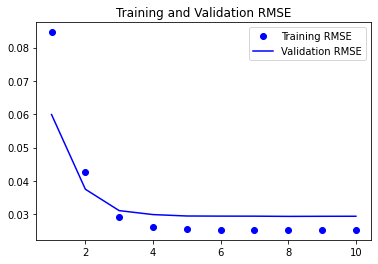

In [5]:
lib.model_summary(model, history, tst)

In [6]:
# More complex model
inputs = keras.Input(shape = (sequence_length, emgModel.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(1200, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_heavy_dense.keras",
 save_best_only=True)
] 
model.compile(optimizer = "rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs = 5,
 validation_data = val,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_heavy_dense.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/5
59/59 [==============================] - 7s 74ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 2/5
59/59 [==============================] - 4s 64ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 3/5
59/59 [==============================] - 3s 59ms/step - loss: 8.7659e-04 - root_mean_squared_error: 0.0296 - val_loss: 8.5458e-04 - val_root_mean_squared_error: 0.0292
Epoch 4/5
59/59 [==============================] - 3s 56ms/step - loss: 6.4781e-04 - root_mean_squared_error: 0.0255 - val_loss: 8.5062e-04 - val_root_mean_squared_error: 0.0292
Epoch 5/5
29/29 [==============================] - 2s 26ms/step - loss: 7.0949e-04 - root_mean_squared_error: 0.0266
Test RMSE: 0.0266


29/29 [==============================] - 1s 27ms/step - loss: 7.0949e-04 - root_mean_squared_error: 0.0266
Test RMSE: 0.0266
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_5 (Dense)             (None, 1200)              1441200   
                                                                 
 dense_6 (Dense)             (None, 100)               120100    
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
 dense_8 (Dense)             (None, 3)                 33        


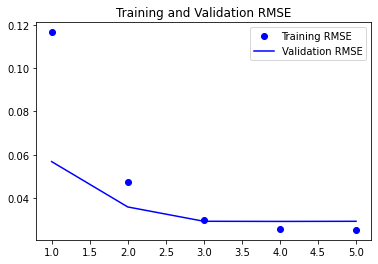

In [7]:
lib.model_summary(model, history, tst)

In [8]:
# Even more complex model
inputs = keras.Input(shape = (sequence_length, emgModel.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(1200, activation="relu")(x)
x = layers.Dense(600, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_heaviest_dense.keras",
 save_best_only=True)
] 
model.compile(optimizer = "rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs = 5,
 validation_data = val,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_heaviest_dense.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/5
59/59 [==============================] - 10s 95ms/step - loss: 0.0614 - root_mean_squared_error: 0.2478 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 2/5
59/59 [==============================] - 5s 83ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 3/5
59/59 [==============================] - 5s 85ms/step - loss: 9.8775e-04 - root_mean_squared_error: 0.0314 - val_loss: 8.6818e-04 - val_root_mean_squared_error: 0.0295
Epoch 4/5
59/59 [==============================] - 5s 81ms/step - loss: 6.5555e-04 - root_mean_squared_error: 0.0256 - val_loss: 8.4948e-04 - val_root_mean_squared_error: 0.0291
Epoch 5/5
29/29 [==============================] - 1s 23ms/step - loss: 7.0720e-04 - root_mean_squared_error: 0.0266
Test RMSE: 0.0266


29/29 [==============================] - 1s 33ms/step - loss: 7.0720e-04 - root_mean_squared_error: 0.0266
Test RMSE: 0.0266
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 1200)              0         
                                                                 
 dense_9 (Dense)             (None, 1200)              1441200   
                                                                 
 dense_10 (Dense)            (None, 600)               720600    
                                                                 
 dense_11 (Dense)            (None, 100)               60100     
                                                                 
 dense_12 (Dense)            (None, 10)                1010      


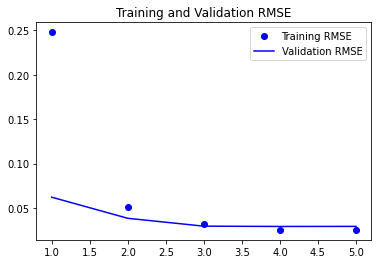

In [9]:
lib.model_summary(model, history, tst)

Conv1D Method:

In [10]:
# Light Model
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.Conv1D(8, 16, activation="relu", padding="causal")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 8, activation="relu", padding="causal")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 4, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_basic_conv1D.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=20,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_basic_conv1D.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/20
59/59 [==============================] - 10s 77ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 2/20
59/59 [==============================] - 3s 57ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 3/20
59/59 [==============================] - 4s 59ms/step - loss: 9.9519e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 4/20
59/59 [==============================] - 3s 59ms/step - loss: 8.3165e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 5/20
59/59 [==============================] - 4s 60ms/step - loss: 7.1574e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 6/20
59/59 [==============================] - 3s 56ms/step - loss: 6.4208e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.

29/29 [==============================] - 1s 31ms/step - loss: 9.3683e-04 - root_mean_squared_error: 0.0306
Test RMSE: 0.0306
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1d (Conv1D)             (None, 100, 8)            1544      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 8)             520       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 8)            0         
 1D)                                                             


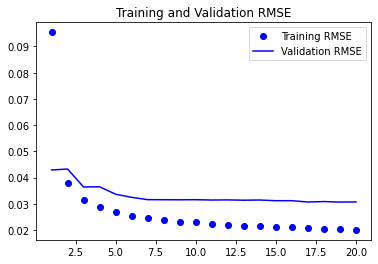

In [11]:
lib.model_summary(model, history, tst)

LSTM:

In [12]:
# Basic LSTM
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_basic_LSTM.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=20,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_basic_LSTM.keras") 
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/20
59/59 [==============================] - 29s 269ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 2/20
59/59 [==============================] - 11s 180ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 3/20
59/59 [==============================] - 11s 181ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 4/20
59/59 [==============================] - 11s 186ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 5/20
59/59 [==============================] - 10s 178ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 6/20
59/59 [==============================] - 10s 166ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0016 

29/29 [==============================] - 2s 65ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412
Test RMSE: 0.0412
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                5760      
                                                                 
 dense_15 (Dense)            (None, 3)                 99        
                                                                 
Total params: 5,859
Trainable params: 5,859
Non-trainable params: 0
_________________________________________________________________
None


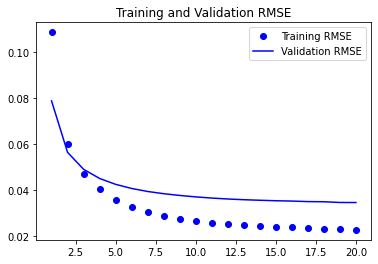

In [13]:
lib.model_summary(model, history, tst)

GRU:

In [15]:
# Basic Stacked GRU
do = 0.8
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.GRU(4, recurrent_dropout=do, return_sequences=True)(inputs)
x = layers.GRU(4, recurrent_dropout=do, return_sequences=True)(x)
x = layers.GRU(4, recurrent_dropout=do)(x)
x = layers.Dropout(do)(x)
x = layers.Dense(4)(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_basic_stacked_GRU.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_basic_stacked_GRU.keras")

Epoch 1/10
59/59 [==============================] - 63s 431ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636
Epoch 2/10
59/59 [==============================] - 22s 374ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 3/10
59/59 [==============================] - 23s 385ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 9.5727e-04 - val_root_mean_squared_error: 0.0309
Epoch 4/10
59/59 [==============================] - 23s 382ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 8.8773e-04 - val_root_mean_squared_error: 0.0298
Epoch 5/10
59/59 [==============================] - 27s 455ms/step - loss: 7.4379e-04 - root_mean_squared_error: 0.0273 - val_loss: 8.7705e-04 - val_root_mean_squared_error: 0.0296
Epoch 6/10
59/59 [==============================] - 28s 479ms/step - loss: 6.5858e-04 - root_mean_squared_error: 0.0257

29/29 [==============================] - 6s 53ms/step - loss: 7.1719e-04 - root_mean_squared_error: 0.0268
Test RMSE: 0.0268
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 gru_3 (GRU)                 (None, 100, 4)            216       
                                                                 
 gru_4 (GRU)                 (None, 100, 4)            120       
                                                                 
 gru_5 (GRU)                 (None, 4)                 120       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_18 (Dense)            (None, 4)                 20        


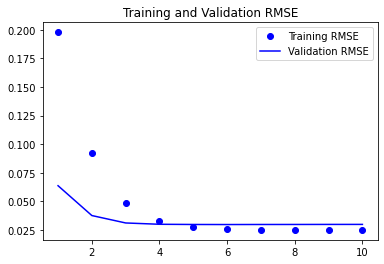

In [16]:
lib.model_summary(model, history, tst)

Models from Literature

Nguyen (2021): (Classification?)

In [17]:
inputs = keras.Input(shape=(sequence_length, input_shape))

# Convolutional layer
x = layers.Conv1D(64, 3, activation="relu", padding="causal")(inputs)
x = layers.BatchNormalization()(x)

# Recurrent layers
x = layers.GRU(512, dropout = 0.5, recurrent_dropout = 0.6, return_sequences = True)(x)
x = layers.GRU(512, dropout = 0.5, recurrent_dropout = 0.6)(x)

# Output layer
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_Nguyen_GRU.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-05,
)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 batch_size=64,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_Nguyen_GRU.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
59/59 [==============================] - 251s 4s/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 2/10
59/59 [==============================] - 246s 4s/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0771
Epoch 3/10
59/59 [==============================] - 2805s 48s/step - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 4/10
59/59 [==============================] - 529s 9s/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 5/10
59/59 [==============================] - 506s 9s/step - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 6/10
59/59 [==============================] - 475s 8s/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0026 - val_root

29/29 [==============================] - 47s 2s/step - loss: 0.0022 - root_mean_squared_error: 0.0469
Test RMSE: 0.0469
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 64)           2368      
                                                                 
 batch_normalization (BatchN  (None, 100, 64)          256       
 ormalization)                                                   
                                                                 
 gru_6 (GRU)                 (None, 100, 512)          887808    
                                                                 
 gru_7 (GRU)                 (None, 512)               1575936   
                                                                 
 dens

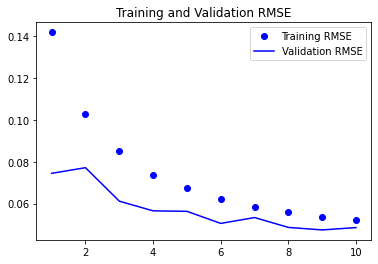

In [18]:
lib.model_summary(model, history, tst)

More brilliance from Nguyen:

Periodgram is used as input in literature, but in this case is relatively sparse of information.

In [ ]:
import scipy.signal as signal
import matplotlib.pyplot as plt

print(emgF.shape)

# Raw signals
lib.plot_emg(tF, emgF)
fs = 1/np.mean(np.diff(tF))

# Periodgram
f, Pxx_den = signal.periodogram(emgF[:,11], fs)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Spectrogram
f, t, Sxx = signal.spectrogram(emgF[:,10], fs, axis=0)
print(Sxx.shape)
# plt.pcolormesh(t, f, Sxx[:,0,:])
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [20]:
inputs = keras.Input(shape=(sequence_length, input_shape))

# Input Layer
x = layers.Conv1D(32, 3, padding="causal")(inputs)
x = layers.BatchNormalization()(x)
x0 = layers.ReLU()(x)

# Residual layer helper function
def res(x0):
    x1 = layers.AveragePooling1D(pool_size=2, strides=2)(x0)
    x = layers.Conv1D(32, 3, strides = 2, padding="causal")(x0)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(32, 3, padding="causal")(x)
    x = layers.Add()([x, x1])
    x = layers.BatchNormalization()(x)
    x0 = layers.ReLU()(x)

    x1 = layers.AveragePooling1D(pool_size=2, strides=2)(x0)
    x = layers.Conv1D(32, 3, strides = 1, padding="causal")(x0)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(32, 3, padding="causal")(x)
    x = layers.Add()([x, x0])
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x0 = layers.Dropout(0.1)(x)
    return x0

# Residual layers (Nguyen uses five, but has larger input dimensions)
x0 = res(x0)
x0 = res(x0)

# Recurrent layers
x = layers.GRU(64, dropout = 0.2, recurrent_dropout = 0, return_sequences = True)(x0)
x1 = layers.GRU(64, dropout = 0.2, recurrent_dropout = 0)(x)

# Attention layers
x = layers.Dense(64, activation="relu")(x1)
x = layers.Dense(1)(x)
x = layers.Multiply()([x, x1])
x = layers.Softmax()(x)

# Output layer
outputs = layers.Dense(output_shape, activation="sigmoid")(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_Nguyen_Stacked.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.Adam(learning_rate=0.01,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-05,
)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 batch_size=64,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_Nguyen_Stacked.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 0.1703 - root_mean_squared_error: 0.4127

C:\Users\nsshi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


59/59 [==============================] - 49s 434ms/step - loss: 0.1703 - root_mean_squared_error: 0.4127 - val_loss: 0.0795 - val_root_mean_squared_error: 0.2819
Epoch 2/10
59/59 [==============================] - 20s 334ms/step - loss: 0.0485 - root_mean_squared_error: 0.2201 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1639
Epoch 3/10
59/59 [==============================] - 21s 356ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 4/10
59/59 [==============================] - 19s 328ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 5/10
59/59 [==============================] - 21s 357ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 6/10
59/59 [==============================] - 21s 361ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0089 - val_root_

29/29 [==============================] - 3s 78ms/step - loss: 0.0080 - root_mean_squared_error: 0.0895
Test RMSE: 0.0895
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 100, 32)      1184        ['input_9[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 100, 32)     128         ['conv1d_4[0][0]']               
 rmalization)                                                                                     
                                                                      

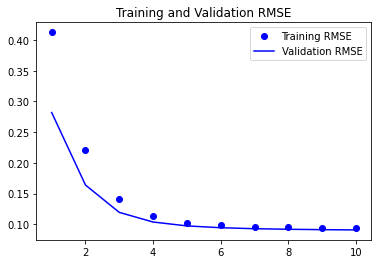

In [21]:
lib.model_summary(model, history, tst)

Luu (2021): Regression Convolutional Neural Network

In [ ]:
inputs = keras.Input(shape=(sequence_length, input_shape))

# Convolutional Layers
# Layer 0
x = layers.Conv1D(32, 3, strides = 1, padding="causal")(inputs)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# Layer 1
x = layers.Conv1D(64, 3, strides = 2, padding="causal")(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# Layer 2
x = layers.Conv1D(64, 3, strides = 1, padding="causal")(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# Layer 3
x = layers.Conv1D(64, 3, strides = 1, padding="causal")(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# Layer 4
x = layers.Conv1D(50, 3, strides = 1, padding="causal")(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)

# Output
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_Luu_Conv1D.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.Adam(learning_rate=0.005,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-05,
)
model.compile(optimizer='adam', loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=5,
 validation_data=val,
 batch_size=64,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_Luu_Conv1D.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

In [ ]:
lib.model_summary(model, history, tst)

Luu (2021): Regression Recurrent Neural Network

In [24]:
inputs = keras.Input(shape=(sequence_length, input_shape))

# Convolutional Layers
# Layer 0
x = layers.Conv1D(32, 3, strides = 1, padding="causal")(inputs)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# Layer 1
x = layers.Conv1D(64, 3, strides = 2, padding="causal")(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# Layer 2
x = layers.Conv1D(64, 3, strides = 1, padding="causal")(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

x = layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0, return_sequences = True)(x)
outputs = layers.LSTM(output_shape, dropout = 0.2, recurrent_dropout = 0)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_Luu_RNN.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.Adam(learning_rate=0.005,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-05,
)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 batch_size=38,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_Luu_RNN.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
59/59 [==============================] - 43s 389ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2/10
59/59 [==============================] - 23s 386ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 9.2615e-04 - val_root_mean_squared_error: 0.0304
Epoch 3/10
59/59 [==============================] - 23s 383ms/step - loss: 9.3251e-04 - root_mean_squared_error: 0.0305 - val_loss: 9.1527e-04 - val_root_mean_squared_error: 0.0303
Epoch 4/10
59/59 [==============================] - 21s 356ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 5/10
59/59 [==============================] - 23s 381ms/step - loss: 8.1287e-04 - root_mean_squared_error: 0.0285 - val_loss: 8.5907e-04 - val_root_mean_squared_error: 0.0293
Epoch 6/10
59/59 [==============================] - 19s 322ms/step - loss: 7.2323e-04 - root_mean_squared_error: 0.

29/29 [==============================] - 2s 77ms/step - loss: 7.4822e-04 - root_mean_squared_error: 0.0274
Test RMSE: 0.0274
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 12)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 100, 32)           1184      
                                                                 
 re_lu_14 (ReLU)             (None, 100, 32)           0         
                                                                 
 batch_normalization_15 (Bat  (None, 100, 32)          128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 100, 32)           0         
                                                                 

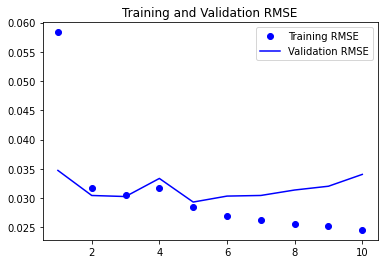

In [25]:
lib.model_summary(model, history, tst)

Lin (2022): (Classification?)

In [26]:
inputs = keras.Input(shape=(sequence_length, input_shape, 1))

# Convolutional Layers
# Layer 0
x = layers.Conv2D(32, (3,int(sequence_length/10)), padding="valid")(inputs)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.MaxPooling2D(pool_size=(1,3))(x)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(32, (3,int(sequence_length/10)), padding="valid")(inputs)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.MaxPooling2D(pool_size=(1,3))(x)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(500)(x)
x = layers.ReLU()(x)
outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_Lin_Conv2D.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.Adam(learning_rate=0.005,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-05,
)
model.compile(optimizer='adam', loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 batch_size=38,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_Lin_Conv2D.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
59/59 [==============================] - 13s 191ms/step - loss: 2.1230 - root_mean_squared_error: 1.4570 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 2/10
59/59 [==============================] - 14s 228ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 3/10
59/59 [==============================] - 14s 238ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 4/10
59/59 [==============================] - 12s 206ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 5/10
59/59 [==============================] - 12s 196ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 6/10
59/59 [==============================] - 14s 228ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0039 

In [ ]:
lib.model_summary(model, history, tst)

Hajin (2022): CNNs

In [ ]:
inputs = keras.Input(shape=(sequence_length, input_shape,1))

# Convolutional Stack 0
# Convolutional Layer 0
x = layers.Conv2D(128, (3,3), padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Convolutional Layer 1
x = layers.Conv2D(128, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Convolutional Layer 2
x = layers.Conv2D(256, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Convolutional Layer 3
x = layers.Conv2D(256, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Convolutional Layer 4
x = layers.Conv2D(256, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.5)(x)

# Output Layer
x = layers.Flatten()(x)

# Convolutional Stack 1
# Convolutional Layer 0
x1 = layers.Conv2D(128, (7,7), padding="same")(inputs)
x1 = layers.BatchNormalization()(x1)
x1 = layers.ReLU()(x1)

# Convolutional Layer 1
x1 = layers.Conv2D(128, (7,7), padding="same")(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.ReLU()(x1)
x1 = layers.MaxPooling2D(pool_size=(2,2))(x1)

# Convolutional Layer 2
x1 = layers.Conv2D(256, (7,7), padding="same")(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.ReLU()(x1)

# Convolutional Layer 3
x1 = layers.Conv2D(256, (7,7), padding="same")(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.ReLU()(x1)
x1 = layers.MaxPooling2D(pool_size=(2,2))(x1)

# Convolutional Layer 4
x1 = layers.Conv2D(256, (7,7), padding="same")(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.ReLU()(x1)
x1 = layers.MaxPooling2D(pool_size=(2,2))(x1)
x1 = layers.Dropout(0.5)(x1)

# Output layer
x1 = layers.Flatten()(x1)

# Aggregation layer
x = layers.Concatenate()([x, x1])
x = layers.Dense(100)(x)
x = layers.ReLU()(x)
x = layers.Dense(50)(x)
x = layers.ReLU()(x)

outputs = layers.Dense(output_shape)(x)

# Construct model and descent algorithm, train, and print test results
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(save_dir + "27_Hajin_Parallel_Stacked.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-05,
)
model.compile(optimizer='adam', loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=15,
 validation_data=val,
 batch_size=128,
 callbacks=callbacks)
model = keras.models.load_model(save_dir + "27_Hajin_Parallel_Stacked.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

In [ ]:
lib.model_summary(model, history, tst)